In [1]:
import sys
import os
sys.path.insert(0,os.path.abspath('/home/xiaoral/py_cuda/lib/python3.9/site-packages'))

In [2]:
import sys
import os
sys.path.insert(0,os.path.abspath('/home/severin/sev_env/lib/python3.9/site-packages'))

In [71]:
import numpy as np
import xgboost as xgb
import stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from src import data_handling as dh
from src import plot

## Functions

In [5]:
def balanced_sampling(df,
                      target, 
                      dataincrease = 0.25, 
                      priority="expression", 
                      exp_limit=0.5,
                      random_state=10, 
                      return_copy=True) -> pd.DataFrame:
        """ 
        Balances data by elimininating most cells with target-expression in [-exp_limit, exp_limit].
        The sample is stratified by patient number to try to get the balance as close as possible
        to the original balance, and by expression to get as a many different values as possible.
        A perfect balance is not possible and therefore one must prioritize one or the other.

        Arguments:
        ----------
        target : str, the target gene to stratify by
        dataincrease : float, the percentage to increase the differentiated datasize by.
        priority : str, what to prioritize in balancing either `expression` or `patient_number`.
        exp_limit : threshold for differentially expressed cells
        random_state : set random state for reproducability
        return_type: wether to return a copy of the dataframe or a slice of it.

        Returns: pandas DataFrame with balanced data. 
        """
        np.random.seed(random_state)

        # Cells that are included based on cell 
        inc_pns = df[abs(df[target])>exp_limit].patient_number.copy()
        exc_pns = df[abs(df[target])<=exp_limit][[target, "patient_number"]].copy()

        exc_pns[target] = pd.cut(exc_pns[target],bins=np.linspace(-exp_limit,exp_limit,6), labels=np.arange(5))
        n_old_rows = inc_pns.shape[0]
        target_b = df.patient_number.value_counts() / df.shape[0]

        n_new_rows = int(inc_pns.shape[0]*dataincrease)
        filler = np.empty(n_new_rows)
        filler.fill(np.nan)

        inc_pns_count = inc_pns.value_counts().copy()
        inc_pns = inc_pns.append(pd.Series(filler))
        missing_pns = list(set(df.patient_number.unique()) - set(inc_pns.unique()))

        balances = np.zeros((n_new_rows, len(df.patient_number.unique())))
        exp_strat = np.zeros(5)

        for p in range(int(inc_pns_count.index.min()), int(inc_pns_count.index.max())):
            if p not in inc_pns_count.index:
                inc_pns_count[p] = 0


        # TODO: This one can be much faster, because the number of cells in each bin is known before we start.
        # That means we can select the cells in parallel. 
        if priority == "expression_alt":
            n = inc_pns.shape[0]
            for i in range(n_old_rows, n):
                
                sys.stdout.write('\r')
                j = (i-n_old_rows + 1) / (n-n_old_rows)
                sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
                sys.stdout.flush()
                
                bin = np.argmin(exp_strat)
                pn_ranking = inc_pns_count.sort_values(ascending=True).index
                for pn in pn_ranking:
                    pn_df = exc_pns[(exc_pns.patient_number==pn) & (exc_pns.ESR1==bin)]
                    if pn_df.shape[0]>0:
                        exp_strat[bin]+=1
                        break

                if pn_df.shape[0]>0:
                    inc_pns_count[pn] += 1

                    index = np.random.randint(pn_df.shape[0])                               # Selects a cell index from the patient
                    inc_pns.at[i-n_old_rows] = pn_df.patient_number[index]                  # Adds the cell to the included list
                    inc_pns.rename(index={i-n_old_rows:pn_df.index[index]},inplace=True)    # Sets the name of the cell in the included list
                    exc_pns.drop(pn_df.index[index], inplace=True) 
                else:
                    print(f"Stopped sampling with {inc_pns.shape[0]-i} samples not found.")
                    break


        elif priority=="expression" or priority=="patient_number":
            for i in trange(n_old_rows, inc_pns.shape[0]):
                current_b = (inc_pns_count / inc_pns.shape[0]).copy()

                for p in missing_pns:
                    if p not in current_b.index:
                        current_b = current_b.append(pd.Series({p:0}))

                inbalance = target_b - current_b
                balances[i-n_old_rows] = inbalance.sort_index()

                if priority=="expression":
                    bin = np.argmin(exp_strat)
                    for pn in inbalance.sort_values(ascending=False).index:
                        pn_df = exc_pns[(exc_pns.patient_number==pn) & (exc_pns.ESR1==bin)]
                        if pn_df.shape[0]>0:
                            exp_strat[bin]+=1
                            break
                    if pn_df.shape[0]==0:


                            raise ValueError("No cells with the needed expression!")

                elif priority=="patient_number":
                    new_pn = inbalance.index[np.argmax(inbalance)][0]
                    for bin in np.argsort(exp_strat):
                        pn_df = exc_pns[(exc_pns.patient_number==new_pn) & (exc_pns.ESR1==bin)]
                        if pn_df.shape[0]>0:
                            exp_strat[bin]+=1
                            break

                inc_pns_count[pn] += 1

                index = np.random.randint(pn_df.shape[0])                               # Selects a cell index from the patient
                inc_pns.at[i-n_old_rows] = pn_df.patient_number[index]                  # Adds the cell to the included list
                inc_pns.rename(index={i-n_old_rows:pn_df.index[index]},inplace=True)    # Sets the name of the cell in the included list
                exc_pns.drop(pn_df.index[index], inplace=True)                          # Removes the cell from the excluded list

        else:
            raise ValueError("priority must be either 'expression', 'expression_alt' or 'patient_number'.")


        if return_copy:
            return df.loc[inc_pns.index].copy()
        else:
            return df.loc[inc_pns.index]

# Data handling
For faster performance don't run cells before "Import clean data". The cells below are for recording the methodology.

## Import

In [95]:
path_to_file = '/data/xiaoral/dataset/new_scaled_merged_cancer.pkl'
path_to_file_full = '/data/xiaoral/dataset/new_data_merged.pkl'

In [96]:
df = pd.read_pickle(path_to_file_full).T

In [97]:
patient_num  = pd.read_pickle('/data/xiaoral/dataset/new_data_metadata.pkl')

In [98]:
patient_num["orig.ident"].shape

(139031,)

## Data cleaning
All cells are cancer cells. 
We standardize patient numbers are across the entire dataset instead of them being trial specific

In [99]:
patients = patient_num["orig.ident"].unique().tolist()
feature_map = {patients[i-1]:i for i in range(1, len(patients)+1)}
patient_num['patient_number'] = patient_num['orig.ident'].map(feature_map)

In [100]:
df["patient_number"] = patient_num["patient_number"]
df["trial"] = patient_num.Trial

## NaN removal
0s are set to NaN and all cells without an ESR1 value are removed. Afterwards all genes with any NaNs are dropped.

In [15]:
df = df.replace({0:np.nan})

In [16]:
df = df[df.ESR1.notna()]

In [17]:
df = df.dropna(axis=1)

In [ ]:
df.to_pickle("/data/severs/datasets/new_data_cleaned.pkl")

# Import clean data

In [6]:
df = pd.read_pickle("/data/severs/datasets/new_data_cleaned.pkl")

## Subsampling 
Without subsampling there is an overrepresentation of nonexpressive cells in the dataset as seen in the figure below.

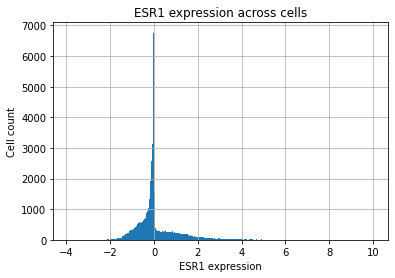

In [7]:
df.ESR1.hist(bins=1000)
plt.title("ESR1 expression across cells")
plt.xlabel("ESR1 expression")
plt.ylabel("Cell count")
plt.show()

### Balanced sampling [does not work]

In [ ]:
df_balanced = balanced_sampling(df, "ESR1", 0.30, priority="expression_alt")

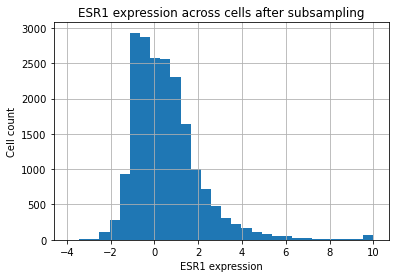

In [121]:
df_balanced.ESR1.hist(bins=30)
plt.title("ESR1 expression across cells after subsampling")
plt.xlabel("ESR1 expression")
plt.ylabel("Cell count")
plt.show()

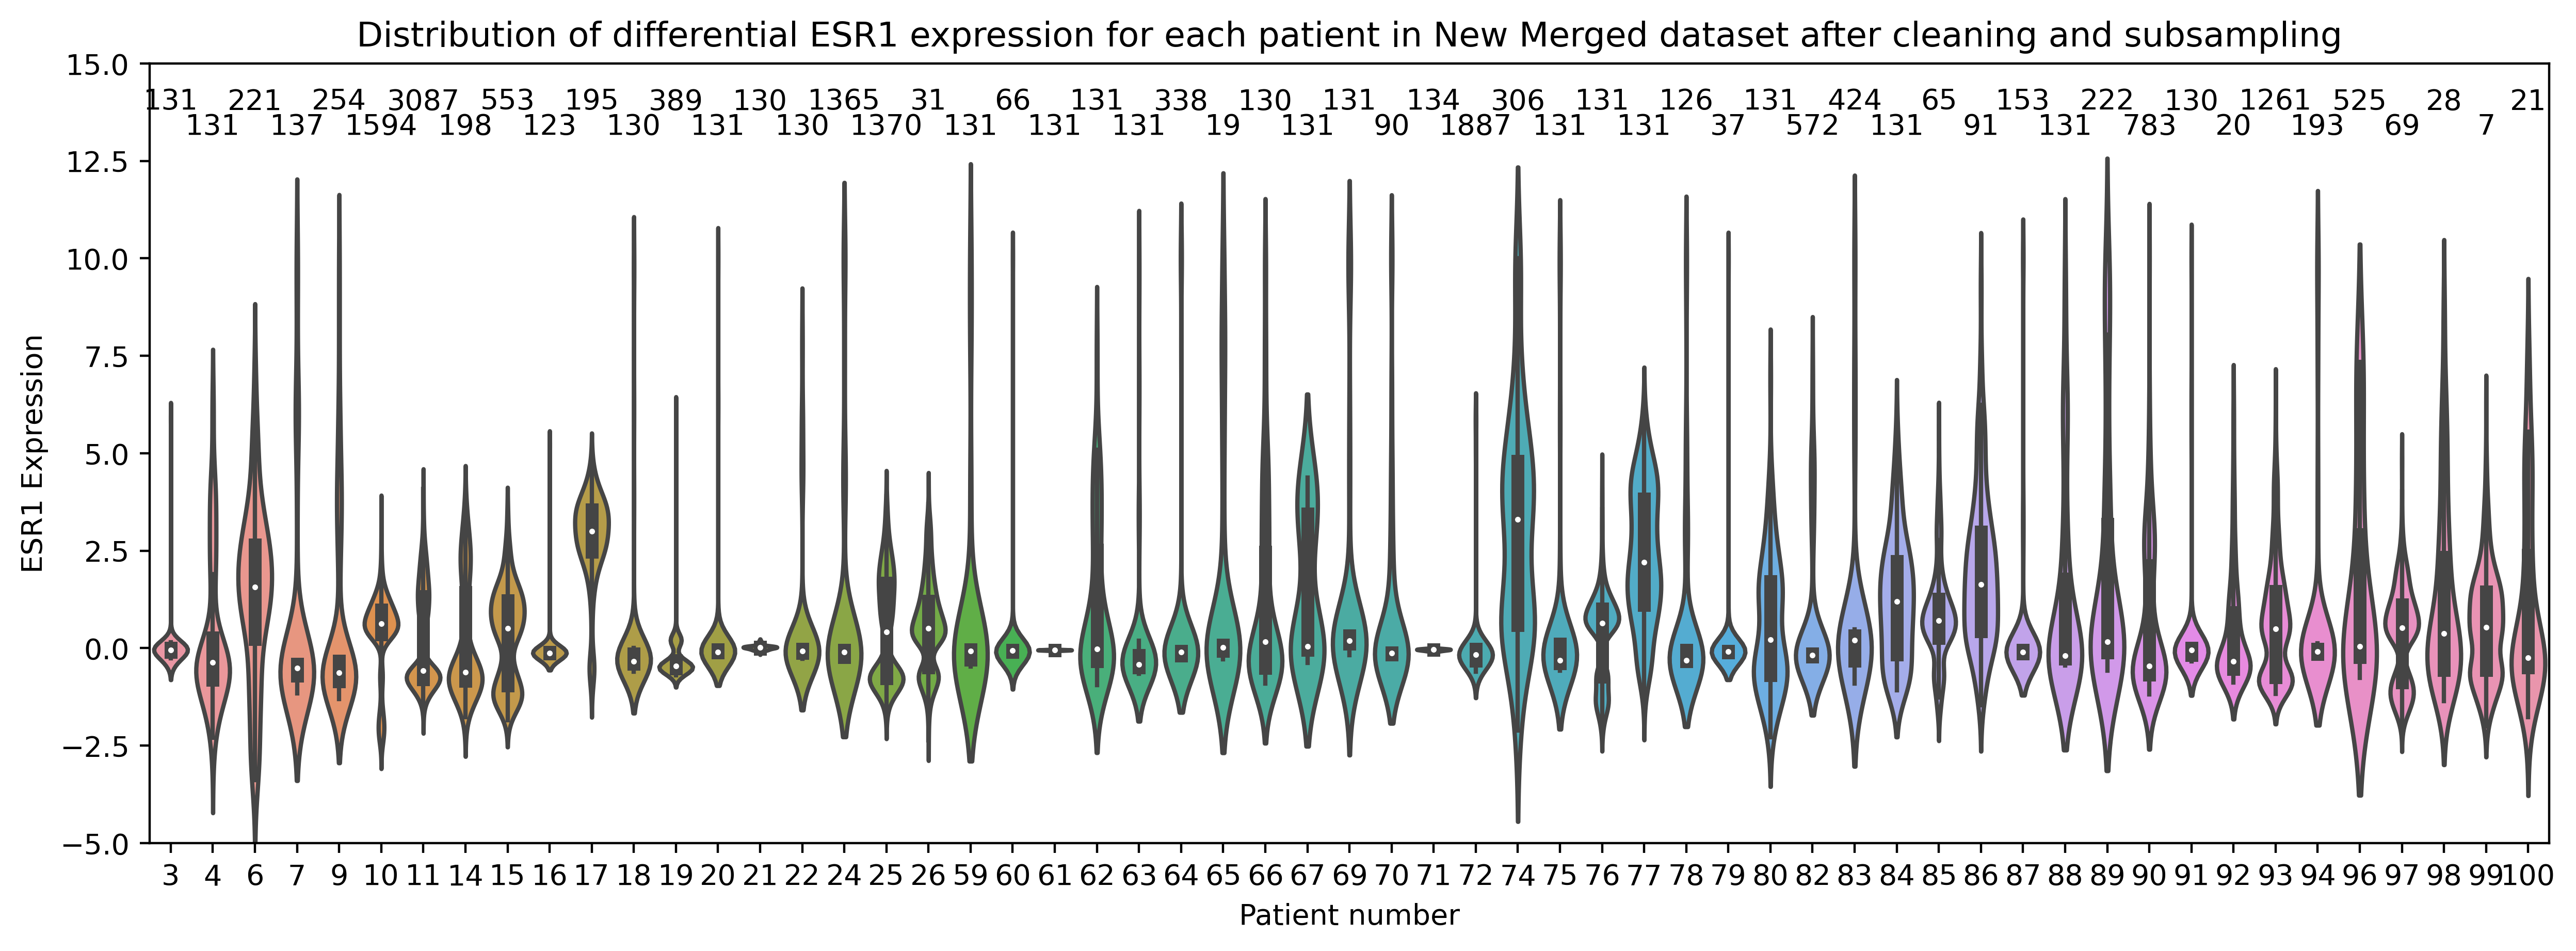

In [122]:
fig, ax = plt.subplots(1,1, dpi=400, figsize=(15,5))
ax = sns.violinplot(x="patient_number", y="ESR1", data=df_balanced, scale="width")
ax.set_xlabel("Patient number")
ax.set_ylabel("ESR1 Expression")
ax.set_title("Distribution of differential ESR1 expression for each patient in New Merged dataset after cleaning and subsampling")
# ax = sns.stripplot(data=bp_cancer.df, x='patient_number', y='ESR1',
#                    color=("white"), edgecolor="black", linewidth=0.3, ax=ax, s=3)
ax.set_ylim(-5, 15)

i = 1
for x, pn in enumerate(df_balanced.patient_number.unique()):
    n = df_balanced.patient_number.value_counts()[pn]
#    if x > 11:
#        x -= 1
    plt.text(x, 13.5 + i*0.32, n,horizontalalignment='center')
    i *= -1

### Manual subsampling

In [8]:
nbins = 250
bins = np.linspace(df.ESR1.min()-0.0001, df.ESR1.max(), nbins)
ESR1_subsampler = pd.cut(df.ESR1,bins=bins, labels=np.arange(nbins-1)).astype(int)

In [56]:
def subsampler(df, method="normal", limit=4000, nbins=250, bottomlimit=200):
    bins = np.linspace(df.ESR1.min()-0.0001, df.ESR1.max(), nbins)
    ESR1_subsampler = pd.cut(df.ESR1,bins=bins, labels=np.arange(nbins-1)).astype(int)
    if method != "normal":
        target = limit
        bottomlimit=limit
    for i in range(nbins):
        n_bin_samples = ESR1_subsampler[ESR1_subsampler==i].shape[0]
        if method=="normal":
            target = int(stats.norm.pdf(bins[i], 0, np.sqrt(2))*4000)
        sys.stdout.write('\r')
        j = (i + 1) / (nbins)
        sys.stdout.write("[%-20s] %d%%    n_bin_samples = %d, target = %d                " % ('='*int(20*j), 100*j, n_bin_samples, target))
        sys.stdout.flush()
        a = ESR1_subsampler[ESR1_subsampler==i]
        if target<n_bin_samples and n_bin_samples>bottomlimit:
            ind_remove = np.random.choice(np.arange(n_bin_samples), n_bin_samples-target, replace=False)
            ESR1_subsampler = ESR1_subsampler.drop(ESR1_subsampler[ESR1_subsampler==i][ind_remove].index)
    return df.loc[ESR1_subsampler.index]

In [ ]:
import scipy.stats as stats

for i in range(nbins):
    n_bin_samples = ESR1_subsampler[ESR1_subsampler==i].shape[0]
    target = int(stats.norm.pdf(bins[i], 0, np.sqrt(2))*4000)
    sys.stdout.write('\r')
    j = (i + 1) / (nbins)
    sys.stdout.write("[%-20s] %d%%    n_bin_samples = %d, target = %d                " % ('='*int(20*j), 100*j, n_bin_samples, target))
    sys.stdout.flush()
    a = ESR1_subsampler[ESR1_subsampler==i]
    if target<n_bin_samples and n_bin_samples>200:
        ind_remove = np.random.choice(np.arange(n_bin_samples), n_bin_samples-target, replace=False)
        ESR1_subsampler = ESR1_subsampler.drop(ESR1_subsampler[ESR1_subsampler==i][ind_remove].index)

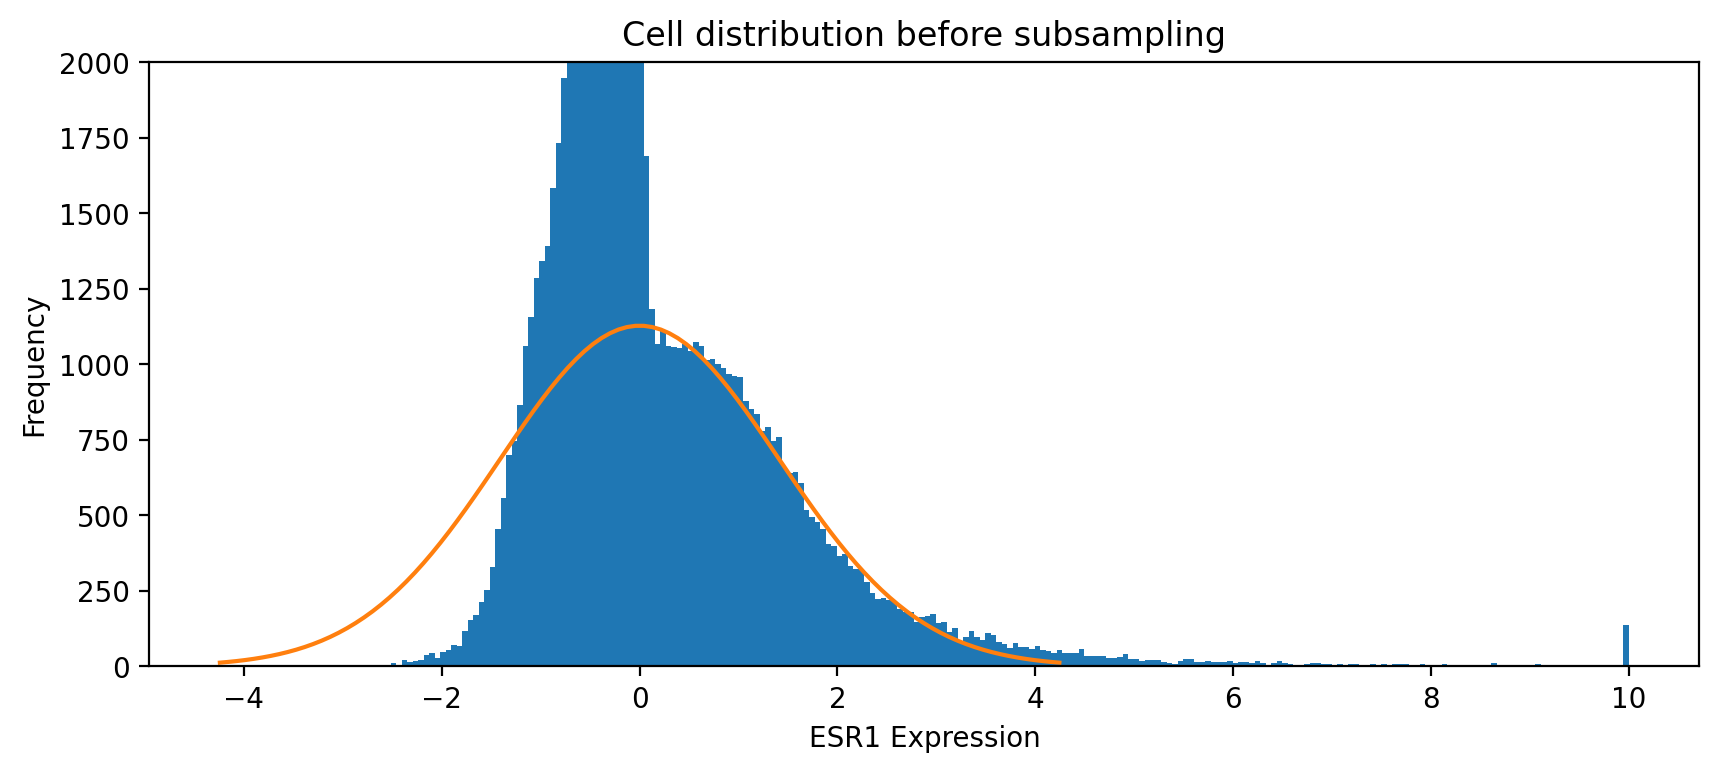

In [15]:
plt.figure(figsize=(10,4), dpi=200)
df.ESR1.plot.hist(bins=250)
mu = 0
variance = 2
plt.ylim(0,2000)
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma)*4000)
plt.title("Cell distribution before subsampling")
plt.xlabel("ESR1 Expression")
plt.show()

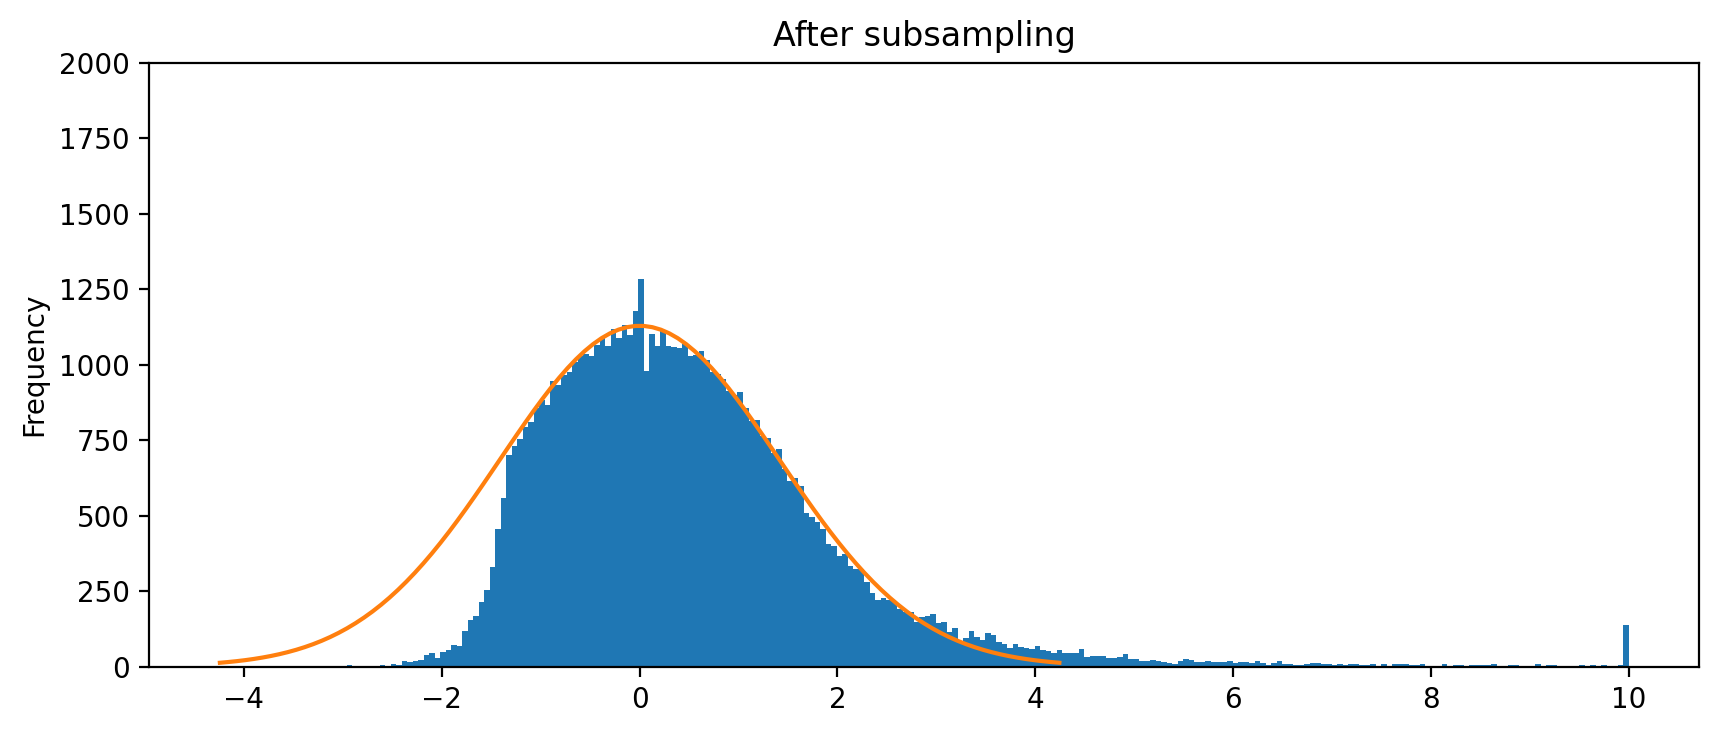

In [14]:
plt.figure(figsize=(10,4), dpi=200)
df.ESR1.loc[ESR1_subsampler.index].plot.hist(bins=250)
plt.ylim(0,2000)
mu = 0
variance = 2
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma)*4000)
plt.title("After subsampling")
plt.show()

In [16]:
dfb = df.loc[ESR1_subsampler.index]

# Controlling for patient number
To control for patient specific variance we one-hot-encode the patient such that they can be used as a categorical variable by the model. 

We drop patients with less than 100 cells

In [17]:
drop = (dfb.patient_number.value_counts()).index[dfb.patient_number.value_counts()<5]

In [18]:
dfb = dfb[~(dfb.patient_number.isin(drop))]

In [19]:
pn = pd.get_dummies(dfb.patient_number, prefix='p')

In [20]:
metadata = dfb[["patient_number", "trial"]]

In [75]:
X = pd.merge(dfb, pn, left_index=True, right_index=True).drop(["patient_number", "trial", "ESR1"], axis=1)

In [76]:
Y = dfb.ESR1

Text(0, 0.5, 'Cell count')

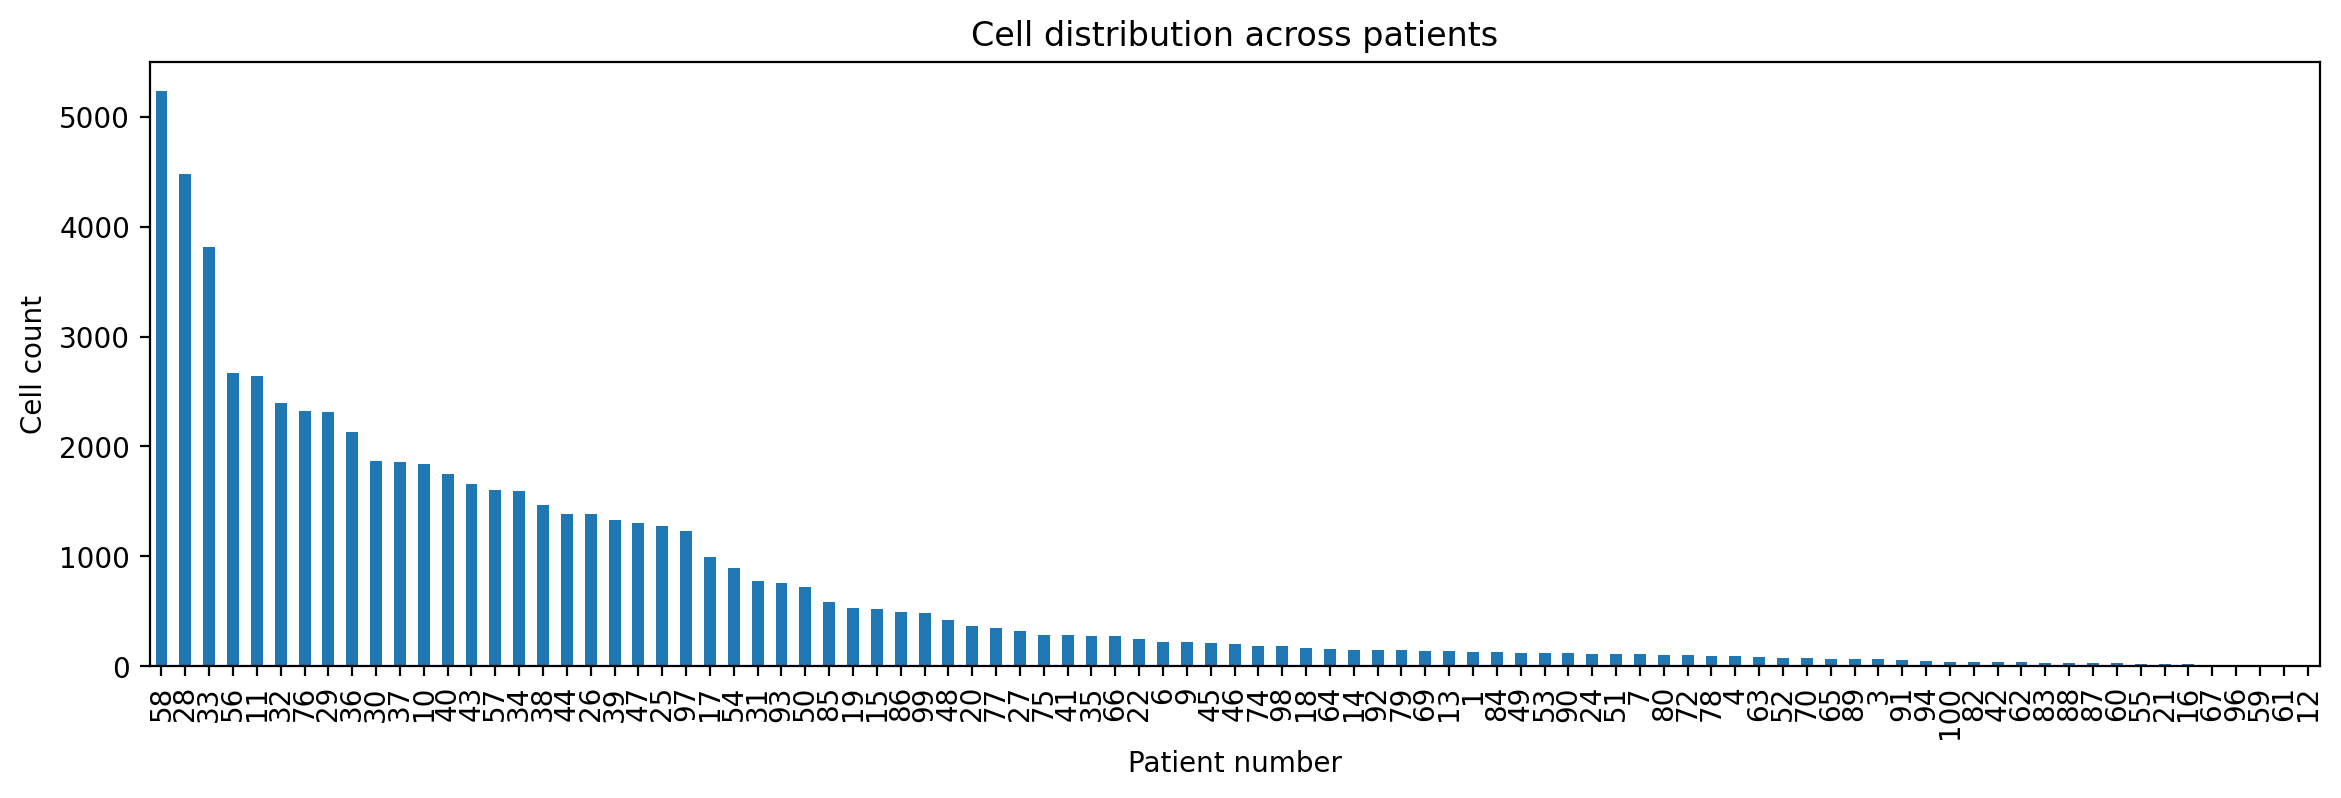

In [39]:
plt.figure(dpi=200, figsize=(14,4))
metadata["patient_number"].value_counts().plot.bar()
plt.title("Cell distribution across patients")
plt.xlabel("Patient number")
plt.ylabel("Cell count")

In [185]:
dfb.shape

(63718, 9002)

In [186]:
df.shape

(137449, 9002)

### Simple stratification

In [23]:
Y_stratifier = pd.cut(Y,bins=np.linspace(Y.min()-0.01, Y.max()+0.01, 10), labels=np.arange(9))

In [77]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
for train, validation in sss.split(metadata.patient_number, metadata.patient_number):
    break

In [78]:
dtrain = xgb.DMatrix(X.iloc[train], label=Y[train], feature_names=X.columns.to_list())

In [86]:
cv_params = {
        'objective': 'reg:squarederror',
        'eta' : 0.05, 
        'max_depth' : 6,
        'subsample' : 1, 
        'colsample_bytree' : 1,
        'eval_metric' :  'rmse',
        'tree_method' : 'gpu_hist',
        'gpu_id' : 0
}

In [87]:
%time cv_result = xgb.cv(cv_params, dtrain, num_boost_round=500, verbose_eval=50)

[0]	train-rmse:1.47504+0.00789	test-rmse:1.48017+0.01641
[50]	train-rmse:1.16675+0.00264	test-rmse:1.32141+0.01272
[100]	train-rmse:1.06033+0.00226	test-rmse:1.30145+0.01283
[150]	train-rmse:0.98461+0.00240	test-rmse:1.29390+0.01290
[200]	train-rmse:0.92456+0.00095	test-rmse:1.29112+0.01310
[250]	train-rmse:0.87173+0.00083	test-rmse:1.28982+0.01342
[300]	train-rmse:0.82210+0.00163	test-rmse:1.28896+0.01333
[350]	train-rmse:0.77732+0.00237	test-rmse:1.28865+0.01362
[400]	train-rmse:0.73576+0.00225	test-rmse:1.28882+0.01351
[450]	train-rmse:0.69665+0.00083	test-rmse:1.28871+0.01370
[499]	train-rmse:0.66093+0.00030	test-rmse:1.28878+0.01377
CPU times: user 4min 2s, sys: 6.69 s, total: 4min 8s
Wall time: 3min 52s


Text(0.5, 1.0, '5-fold cross validation on training set')

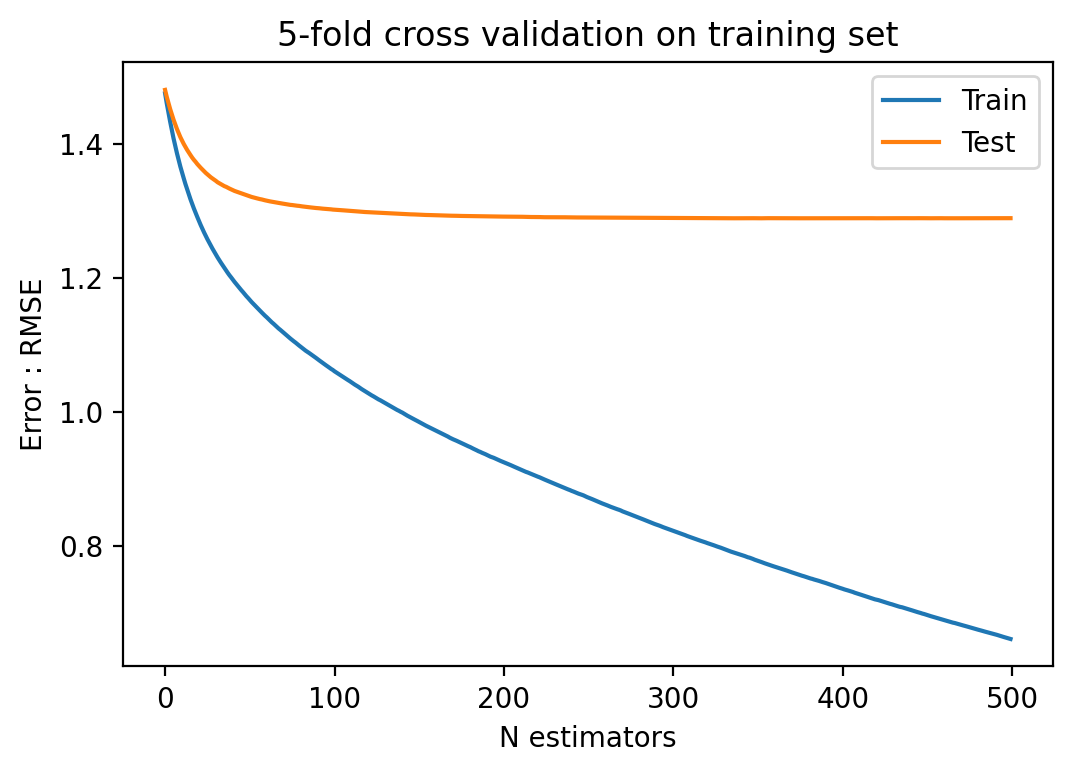

In [88]:
plt.figure(dpi=200)
plt.plot(cv_result["train-rmse-mean"], label="Train")
plt.plot(cv_result["test-rmse-mean"], label="Test")
plt.legend()
plt.xlabel("N estimators")
plt.ylabel("Error : RMSE")
plt.title("5-fold cross validation on training set")

In [89]:
num_round = 500

param = {
    "eta": 0.05,
    "max_depth": 6,
    'tree_method' : 'gpu_hist',
    'gpu_id' : 0
}
%time model = xgb.train(param, dtrain,num_round)

CPU times: user 1min 1s, sys: 438 ms, total: 1min 1s
Wall time: 54.8 s


In [90]:
model.set_param({"predictor": "gpu_predictor"})

In [91]:
%%time
# Compute shap values using GPU with xgboost
# model.set_param({"predictor":"cpu_predictor"})

dtest = xgb.DMatrix(X.iloc[validation], label=Y[validation], feature_names=X.columns.to_list())
y_pred = model.predict(dtest, pred_contribs=False)

CPU times: user 26.8 s, sys: 1.1 s, total: 27.9 s
Wall time: 3.45 s


In [118]:
y_pred_train = model.predict(dtrain, pred_contribs=False)

In [92]:
from sklearn.metrics import r2_score, mean_squared_error

In [93]:
r2_score(Y[train], y_pred_train)

0.9999668742625427

In [94]:
np.sqrt(mean_squared_error(Y[train], y_pred_train))

0.008582476139550523

In [95]:
r2_score(Y[validation], y_pred)

0.2671055458337239

In [130]:
bignegerrs = np.where(Y[validation]-y_pred>3)[0]

<module 'matplotlib.pyplot' from '/home/severs/.local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

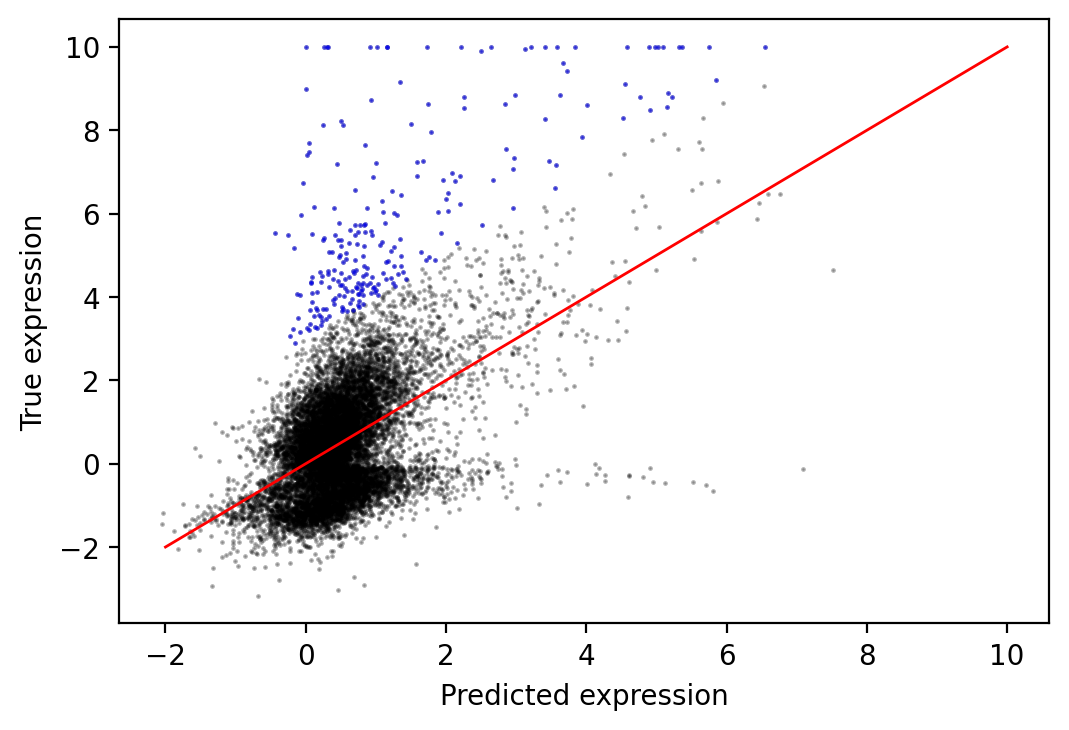

In [129]:
plt.figure(dpi=200)
plt.scatter(y_pred, Y[validation], s=0.5, color="black", alpha=0.3)
plt.scatter(y_pred[bignegerrs], Y[validation][bignegerrs], s=0.5, color="blue", alpha=0.5)
plt.plot([-2, 10], [-2, 10], color="red", linewidth=1)
plt.xlabel("Predicted expression")
plt.ylabel("True expression")
plt

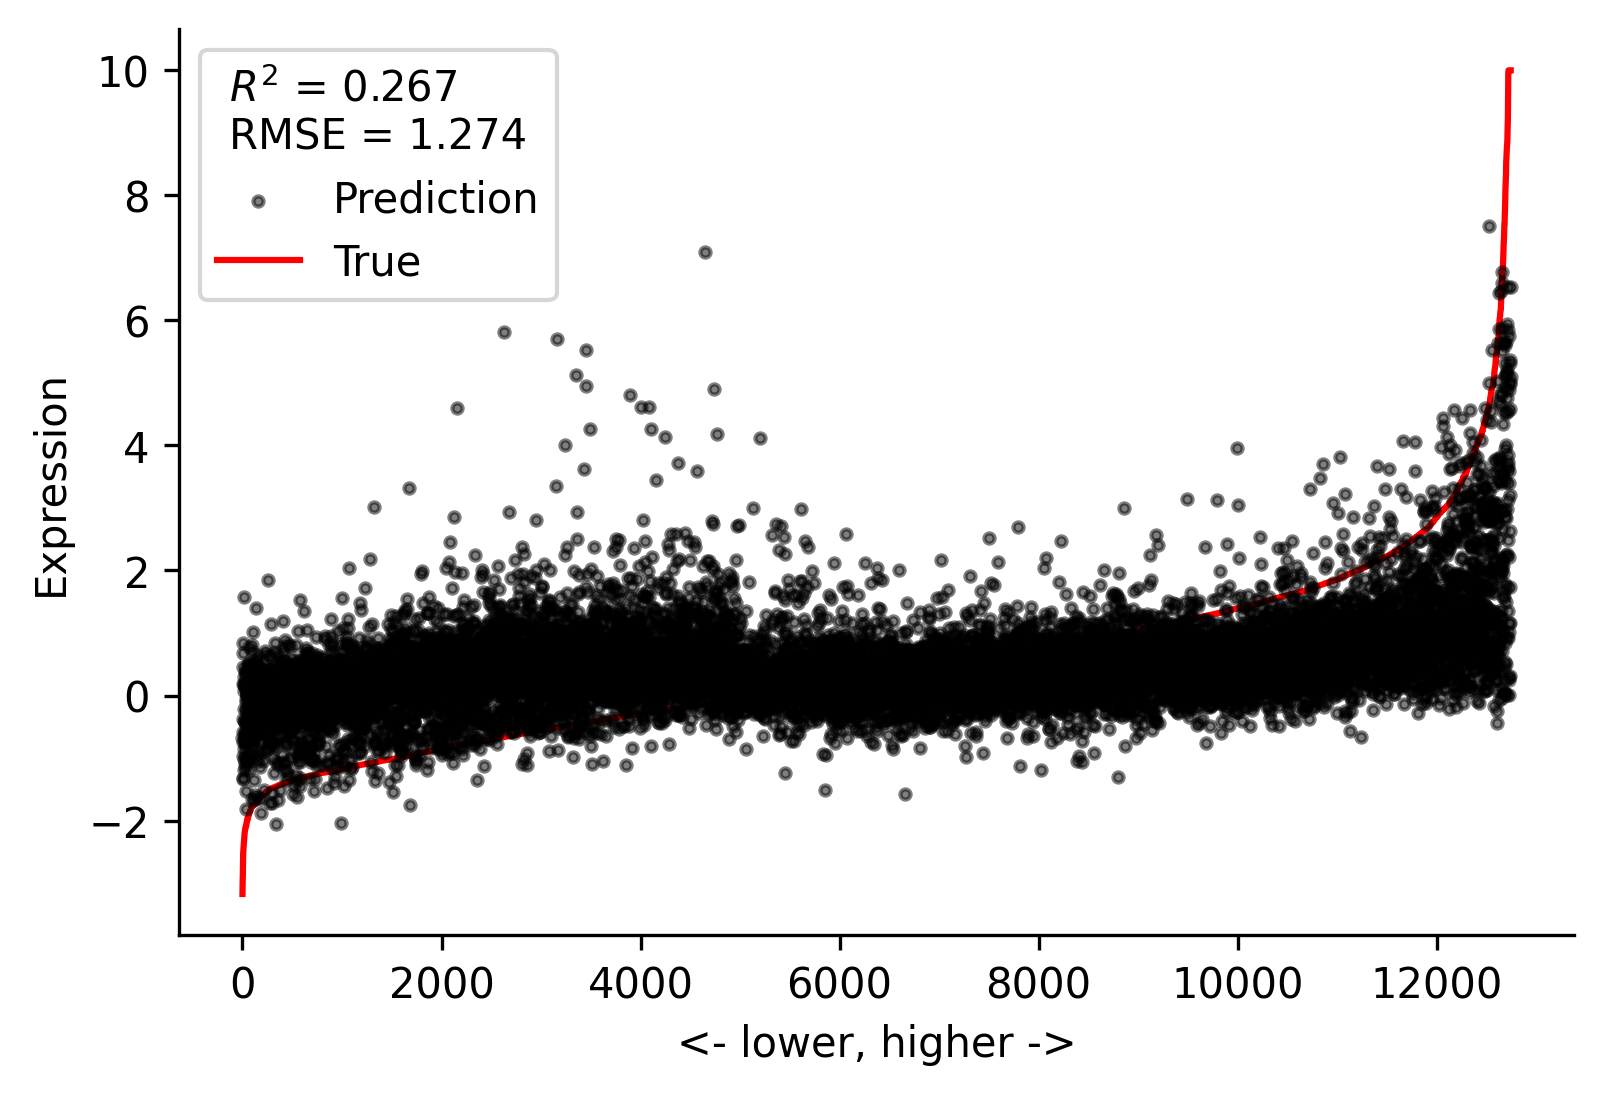

In [96]:
fig, ax = plt.subplots(dpi=300)
plot.plot_prediction(Y[validation],
                  y_pred,
                  cmap="nipy_spectral",
                  fig=fig,
                  ax=ax)
plt.show()

In [111]:
# Use the shap package
import shap


# shap will call the GPU accelerated version as long as the predictor parameter is set to "gpu_predictor"
model.set_param({"predictor": "gpu_predictor"})
explainer = shap.TreeExplainer(model)
%time shap_values = explainer.shap_values(X.iloc[validation])

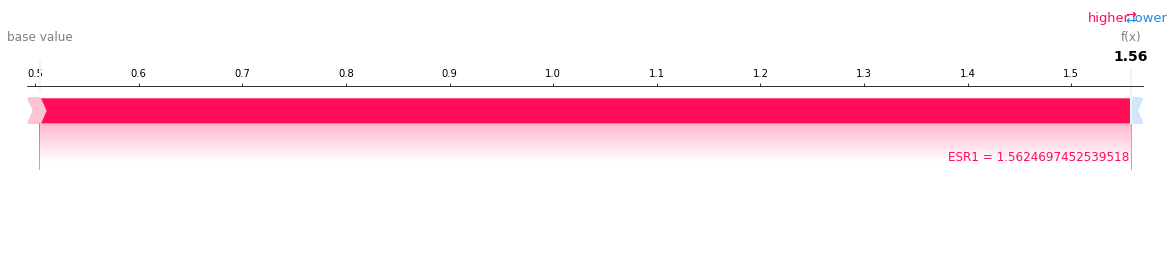

In [72]:
# visualize the first prediction's explanation
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X.iloc[validation].iloc[0,:],
    feature_names=X.iloc[validation].columns.to_list(),
    matplotlib=True
)

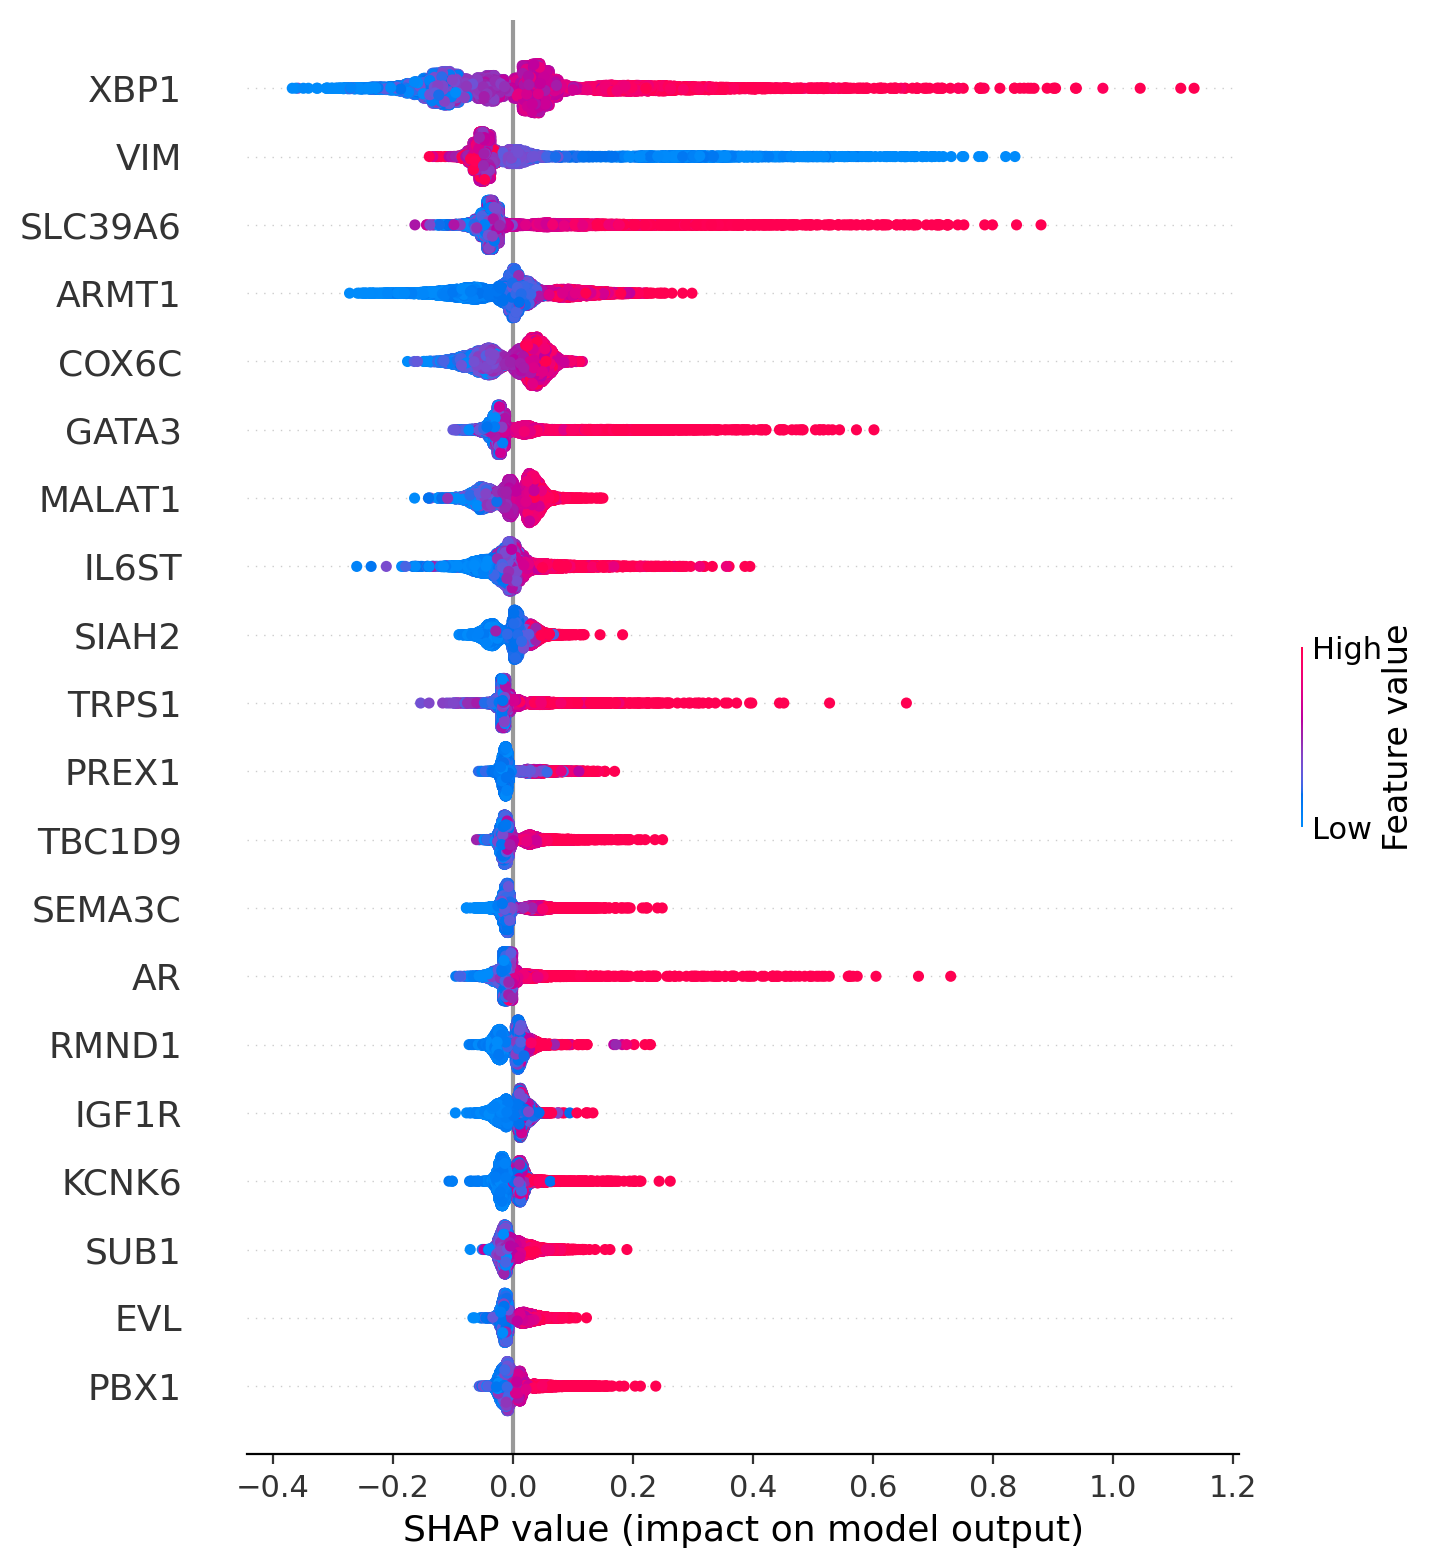

In [116]:
# Show a summary of feature importance
plt.figure(dpi=200)
shap.summary_plot(shap_values, X.iloc[validation], feature_names=X.iloc[validation].columns.to_list())

# Patient specific model

## Patient 58
It is the patient with the second most cells and a "decent" amount of expressive variance in ESR1

In [68]:
X58 = df[df["patient_number"]==58].drop(["patient_number", "trial", "ESR1"], axis=1)

In [69]:
Y58 = df[df["patient_number"]==58].ESR1

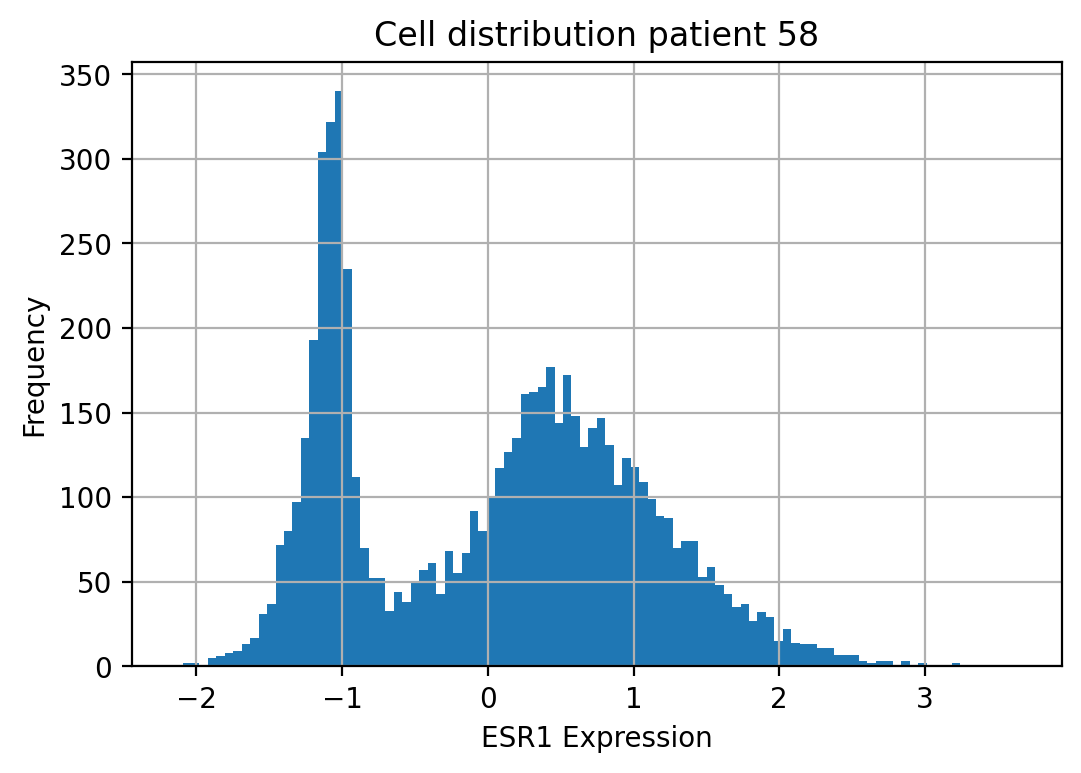

In [174]:
plt.figure(dpi=200)
Y58.hist(bins=100)
plt.title("Cell distribution patient 58")
plt.xlabel("ESR1 Expression")
plt.ylabel("Frequency")
plt.show()

In [72]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
strat58 = pd.cut(Y58, bins=10)
for train58, test58 in sss.split(strat58, strat58):
    break

In [73]:
dtrain58 = xgb.DMatrix(X58, label=Y58, feature_names=X58.columns.to_list())

In [74]:
cv_params = {
        'objective': 'reg:squarederror',
        'eta' : 0.05, 
        'max_depth' : 6,
        'subsample' : 1, 
        'colsample_bytree' : 1,
        'eval_metric' :  'rmse',
        'tree_method' : 'gpu_hist',
        'gpu_id' : 0
}

In [172]:
%time cv_result = xgb.cv(cv_params, dtrain58, num_boost_round=100, verbose_eval=50)

[0]	train-rmse:1.08010+0.00716	test-rmse:1.08715+0.01462
[50]	train-rmse:0.66332+0.00343	test-rmse:0.96493+0.00553
[99]	train-rmse:0.49751+0.00300	test-rmse:0.96315+0.00411
CPU times: user 50.5 s, sys: 2.63 s, total: 53.1 s
Wall time: 41.4 s


Text(0.5, 1.0, '5-fold cross validation on patient 58')

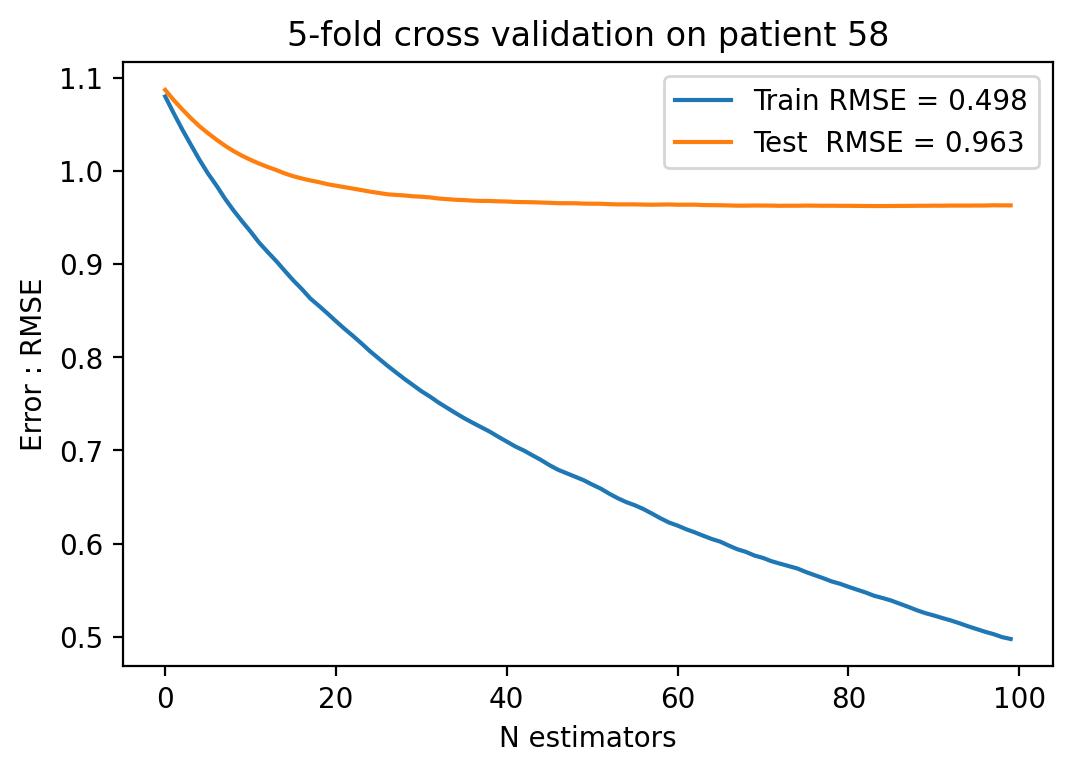

In [173]:
plt.figure(dpi=200)
plt.plot(cv_result["train-rmse-mean"], label=f'Train RMSE = {cv_result["train-rmse-mean"].iloc[-1]:.3f}')
plt.plot(cv_result["test-rmse-mean"], label=f"Test  RMSE = {cv_result['test-rmse-mean'].iloc[-1]:.3f}")
plt.legend()
plt.xlabel("N estimators")
plt.ylabel("Error : RMSE")
plt.title("5-fold cross validation on patient 58")

In [75]:
num_round = 100

param = {
    "eta": 0.05,
    "max_depth": 6,
    'tree_method' : 'gpu_hist',
    'gpu_id' : 0
}
%time model58 = xgb.train(param, dtrain58, num_round)

CPU times: user 13.6 s, sys: 177 ms, total: 13.8 s
Wall time: 7.52 s


In [76]:
%%time
# Compute shap values using GPU with xgboost
# model.set_param({"predictor":"cpu_predictor"})

dtest58 = xgb.DMatrix(X58.iloc[test58], label=Y58[test58], feature_names=X58.columns.to_list())
y_pred58 = model58.predict(dtest58, pred_contribs=False)

CPU times: user 17.5 s, sys: 405 ms, total: 17.9 s
Wall time: 1.03 s


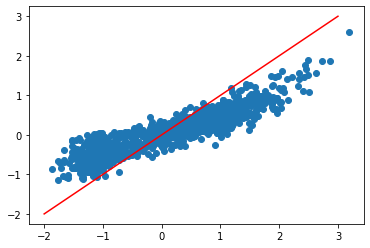

In [183]:
plt.scatter(Y58[test58],
                  y_pred58)
plt.plot([-2,3],[-2,3], color="red")

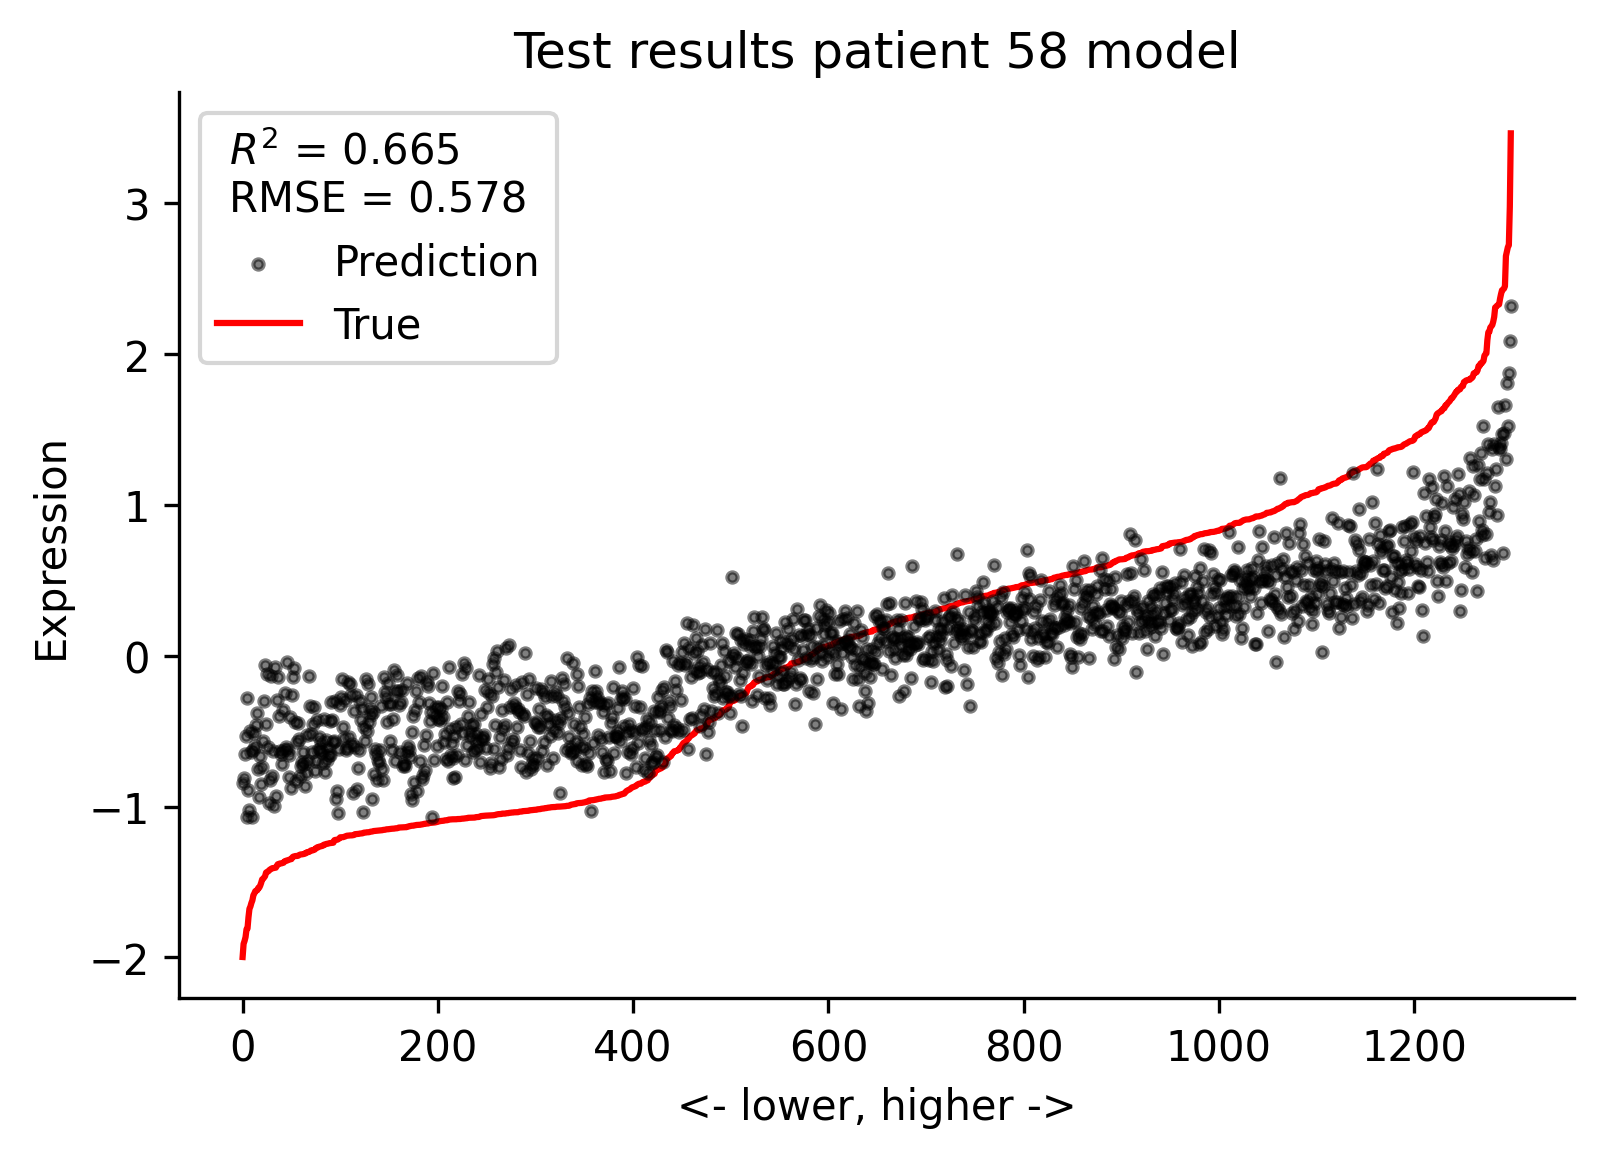

In [77]:
fig, ax = plt.subplots(dpi=300)
plot.plot_prediction(Y58[test58],
                  y_pred58,
                  cmap="nipy_spectral",
                  fig=fig,
                  ax=ax)
plt.title("Test results patient 58 model")
plt.show()

In [78]:
shap58 = model58.predict(dtest58, pred_contribs=True)

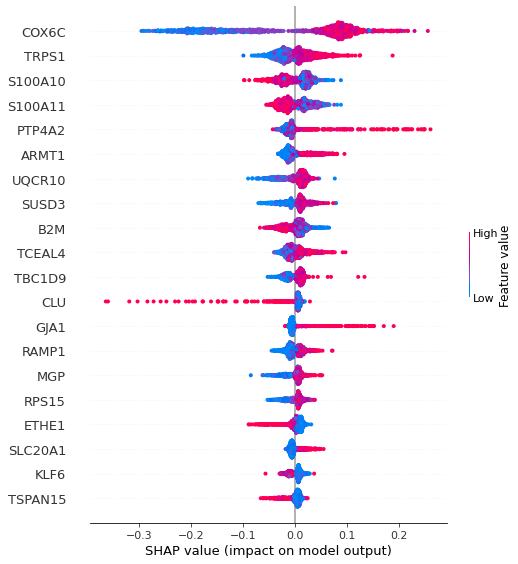

In [83]:
shap.summary_plot(shap58[:,:-1], X58.iloc[test58])

In [187]:
from sklearn.linear_model import LassoCV

In [191]:
alphas = np.logspace(-2, 0,10)

In [192]:
LassoCV(

array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])

In [ ]:
reg = LassoCV(cv=5, random_state=0, n_jobs=20, n_alphas=20).fit(X58.iloc[train58].values, Y58[train58].values)

## Patient 56

In [101]:
df56 = subsampler(df[df["patient_number"]==56], method=None, limit=50)

[====================] 100%    n_bin_samples = 0, target = 50                 

In [103]:
df56 = df56.replace({0:np.nan})

In [104]:
df56 = df56[df56.ESR1.notna()]

In [105]:
df56 = df56.dropna(axis=1)

In [106]:
df56.shape

(3304, 22774)

In [107]:
X56 = df56.drop(["ESR1", "trial", "patient_number"], axis=1)
Y56 = df56.ESR1

In [108]:
dtrain56 = xgb.DMatrix(X56, label=Y56)
%time cv_result = xgb.cv(cv_params, dtrain56, num_boost_round=100, verbose_eval=50)

[0]	train-rmse:1.30400+0.01203	test-rmse:1.32128+0.02349
[50]	train-rmse:0.68644+0.02885	test-rmse:1.26523+0.02907
[99]	train-rmse:0.46575+0.02913	test-rmse:1.26502+0.02584
CPU times: user 1min 12s, sys: 22.5 s, total: 1min 34s
Wall time: 1min 23s


In [66]:
cv_params = {
        'objective': 'reg:squarederror',
        'eta' : 0.05, 
        'max_depth' : 6,
        'subsample' : 1, 
        'colsample_bytree' : 1,
        'eval_metric' :  'rmse',
        'tree_method' : "exact",
        "n_jobs" : 20
}

(4543,)


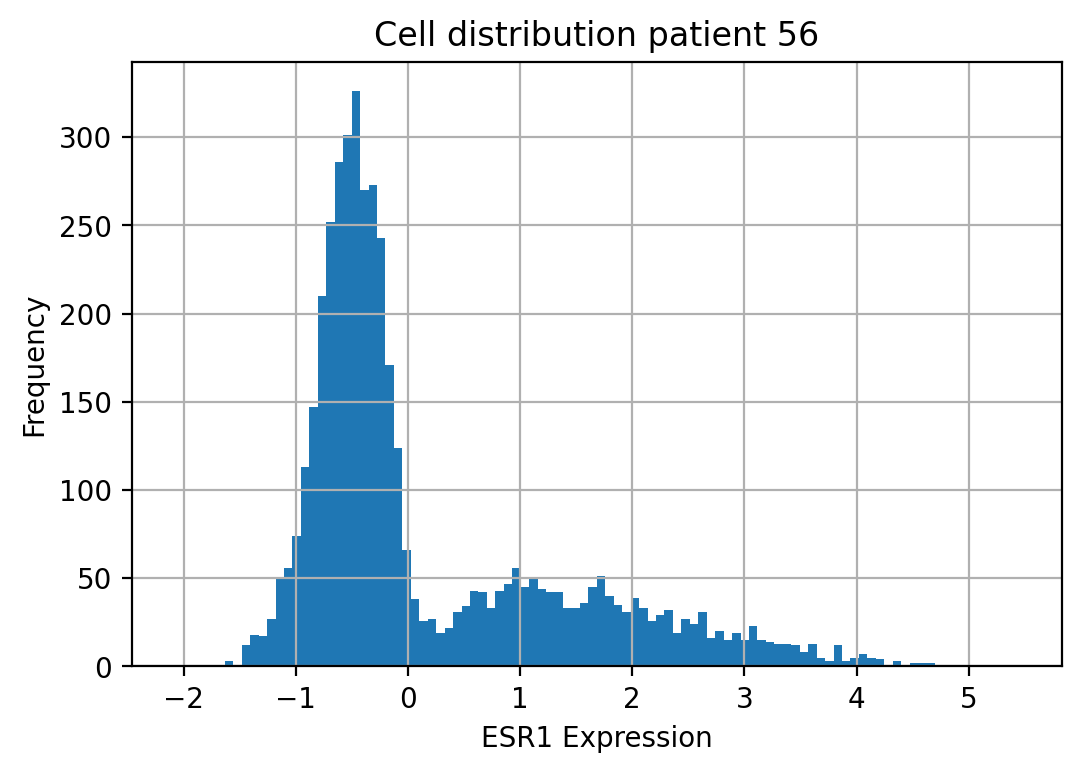

In [59]:
p=56
plt.figure(dpi=200)
df[df["patient_number"]==p].ESR1.hist(bins=100)
plt.title(f"Cell distribution patient {p}")
plt.xlabel("ESR1 Expression")
plt.ylabel("Frequency")
print(df[df["patient_number"]==p].ESR1.shape)
plt.show()

In [87]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
strat56 = pd.cut(Y56, bins=10)
for train56, test56 in sss.split(strat56, strat56):
    break

In [88]:
dtrain56 = xgb.DMatrix(X56.iloc[train56], label=Y56[train56])

In [92]:
num_round = 300

param = {
    "eta": 0.05,
    "max_depth": 6,
    'tree_method' : 'gpu_hist',
    'gpu_id' : 0
}
%time model56 = xgb.train(param, dtrain56, num_round)

CPU times: user 25.3 s, sys: 2.32 s, total: 27.6 s
Wall time: 18.7 s


In [93]:
%%time
# Compute shap values using GPU with xgboost
# model.set_param({"predictor":"cpu_predictor"})

dtest56 = xgb.DMatrix(X56.iloc[test56], label=Y56[test56], feature_names=X56.columns.to_list())
y_pred56 = model56.predict(dtest56, pred_contribs=False)

CPU times: user 16.6 s, sys: 423 ms, total: 17.1 s
Wall time: 1.07 s


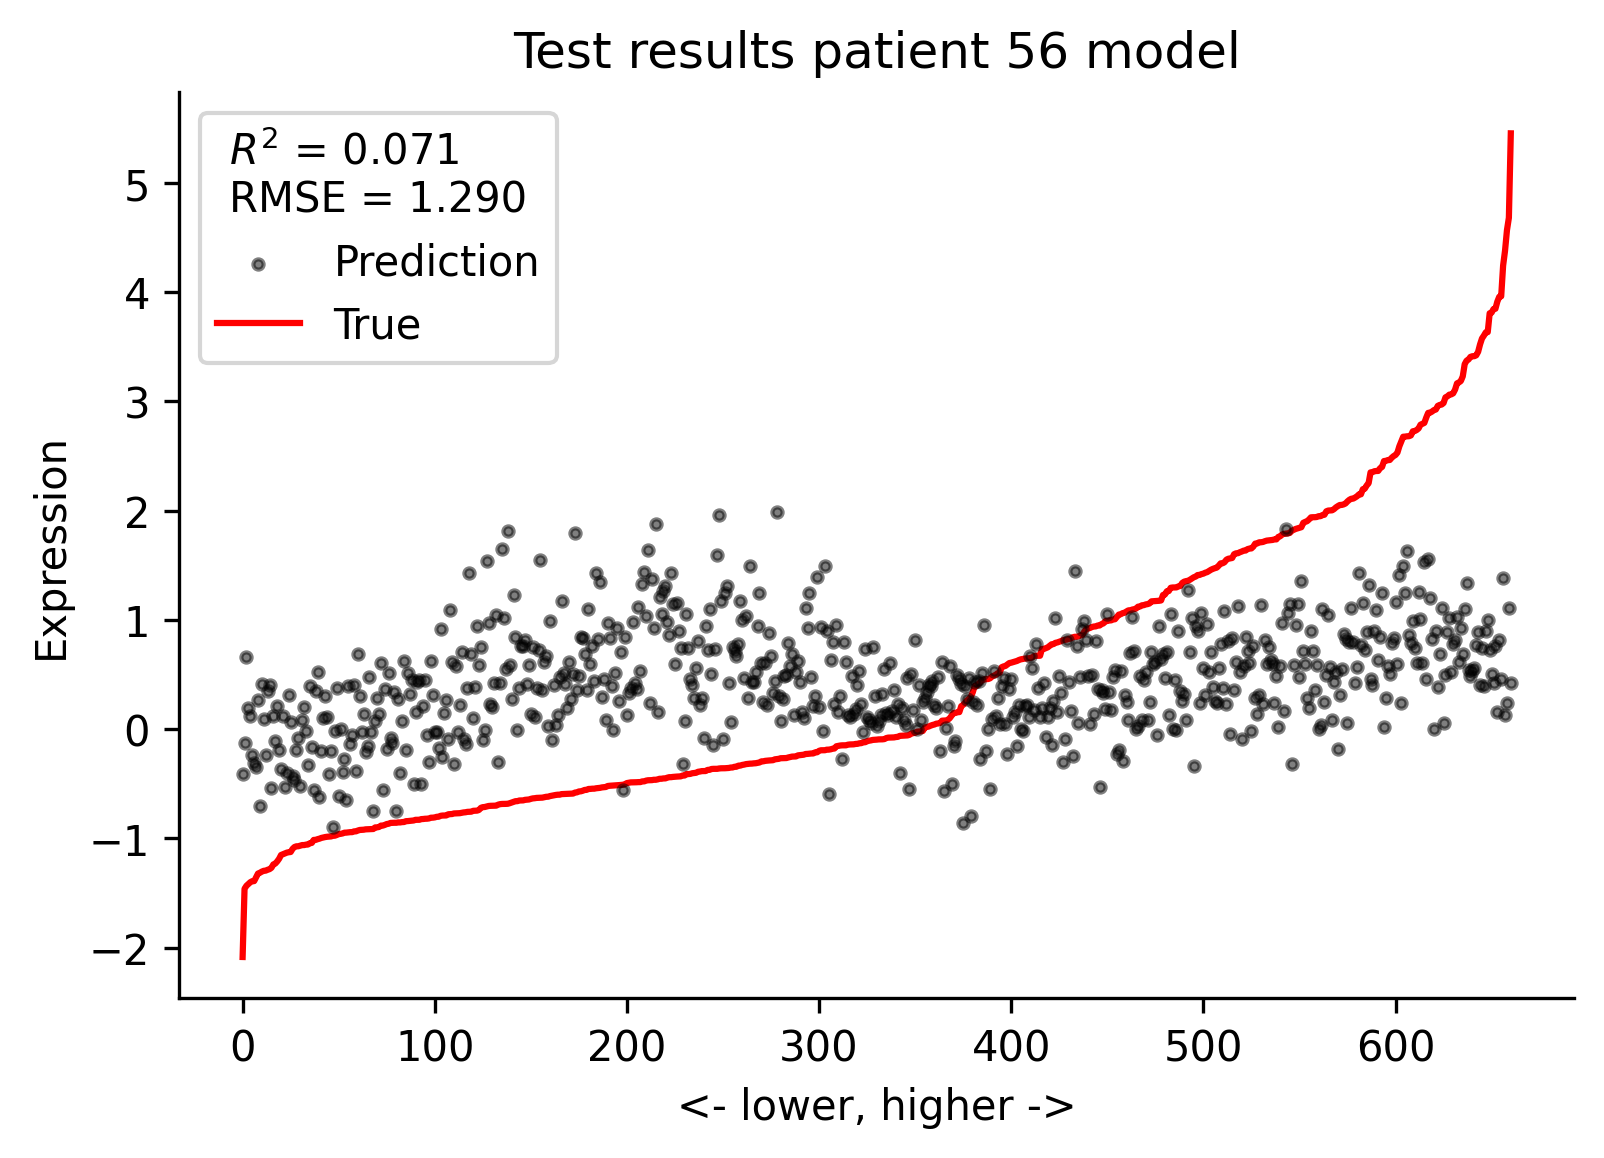

In [94]:
fig, ax = plt.subplots(dpi=300)
plot.plot_prediction(Y56[test56],
                  y_pred56,
                  cmap="nipy_spectral",
                  fig=fig,
                  ax=ax)
plt.title("Test results patient 56 model")
plt.show()